In [1]:
import numpy as np
import networkx as nx
import networkx.generators.random_graphs as nxrg

In [2]:
def adjacency_gen(nnodes, undirected = False):
    adj = np.random.randint(2, size = (nnodes, nnodes), dtype = int)
    for i in range(nnodes):
        adj[i,i] = 0
    if(undirected):
        for i in range(nnodes):
            for j in range(i):
                adj[i,j] = adj[j,i]
    return adj

In [49]:
def flow_gen(adj, paths, nsample, Range=10, zero_centered=False, backflow = False, processed_paths = False, noise_level=0.2):
    '''
    generates flow samples based on eigenpaths with gaussian noise
    input:
    adj: adjacency matrix of graph, rows represent staring nodes, columns representing destination nodes
    paths: eigenpaths of a fixed length, 
        must be in the format [s1, d1, w1], [s2=d1, d2, w2], ... [sl=d(l-1), dl, wl]
        where s is the starting node of the edge, d is the ending node of the edge
        and w is the weight of each edge in the path
    nsample: number of samples generated
    backflow: allow edge adjacency matrix to have backflow, making it symetric
    noise: add gaussian noise or not
    
    output:
    sample: nsample * nedges np array
    edge_adj: edge adjacency matrix
    '''
    nEdges = 0
    #encode adjacency matrix into edge vector
    Edges = []
    for start in range(adj.shape[0]):
        for dest in range(adj.shape[0]):
            if(adj[start, dest] == 1):
                nEdges += 1
                Edges.append([start, dest])
    
    Paths = np.zeros((len(paths), nEdges), dtype = float)
    if processed_paths == False:
        for p in paths:
            prev_end = None
            for e in p:
                assert adj[e[0], e[1]] == 1 #all paths must exist
                assert prev_end is None or e[0] == prev_end #all paths must be valid
                prev_end = e[1]

        for p in range(len(paths)):
            for e in range(len(paths[p])):
                Paths[p, Edges.index(paths[p][e][0:2])] = paths[p][e][2]
    else:
        Paths = paths
    
    print("Edges:\n", Edges)
    print("Paths:\n", Paths)
    
    sample = np.zeros((nsample, nEdges), dtype = float)
    noiseless_sample = np.zeros((nsample, nEdges), dtype = float)
    for i in range(nsample):
        w = np.random.rand(len(paths))*Range #random weight for each path
        if zero_centered == True:
            w = w - Range/2
        sample[i,:] += w@Paths + Range * noise_level*np.random.randn(nEdges)
        noiseless_sample[i,:] += w@Paths
        
    #transform adjacency matrix into edge adjacecny matrix
    edge_adj = np.zeros((nEdges, nEdges), dtype = int)
    for e in range(nEdges):
        for i in range(adj.shape[0]):
            if(adj[Edges[e][1], i] == 1):
                edge_adj[e, Edges.index([Edges[e][1], i])] = 1
    
    if(backflow == True):
        for i in range(nEdges):
            for j in range(i):
                if(edge_adj[i.j] == 1 or edge_adj[j,i] == 1):
                    edge_adj[i,j] = 1 
                    edge_adj[j,i] = 1
    
    return sample, noiseless_sample, edge_adj, Paths

In [4]:
def path_gen(paths, weighted = False):
    results = []
    for pth in paths:
        print(pth)
        w_pth = []
        if weighted:
            weights = np.random.uniform(low = 5.0, high = 15.0, size = (len(pth)-1, ))
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], int(weights[i]) ])
        else:
            for i in range(len(pth) - 1):
                w_pth.append([pth[i], pth[i+1], 1 ])
            
        results.append(w_pth)
    return results

In [13]:
G = adjacency_gen(10, undirected = False)
print(G)

[[0 1 1 0 1 1 1 1 0 0]
 [0 0 0 1 0 1 0 1 0 1]
 [1 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 0 1 0 0 1]
 [0 0 1 0 1 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 1 1]
 [0 1 1 0 1 1 0 1 0 1]
 [0 1 0 0 0 1 0 0 0 0]]


In [52]:
gnp = nxrg.fast_gnp_random_graph(30, 0.3, seed=None, directed=False)
gnp_G = nx.adjacency_matrix(gnp).toarray()
print(gnp_G)

[[0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1]
 [1 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0]
 [1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0]
 [0 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0]
 [1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1]
 [1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0]
 [1 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1]
 [1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0

In [47]:
swg = nxrg.newman_watts_strogatz_graph(10, 4, 0.3)
swg_G = nx.adjacency_matrix(swg).toarray()
print(swg_G)

[[0 1 1 0 0 1 0 0 1 1]
 [1 0 1 1 1 0 0 0 0 1]
 [1 1 0 1 1 0 0 0 0 0]
 [0 1 1 0 1 1 0 1 0 0]
 [0 1 1 1 0 1 1 1 1 0]
 [1 0 0 1 1 0 1 1 1 0]
 [0 0 0 0 1 1 0 1 1 1]
 [0 0 0 1 1 1 1 0 1 1]
 [1 0 0 0 1 1 1 1 0 1]
 [1 1 0 0 0 0 1 1 1 0]]


In [5]:
sfg = nxrg.barabasi_albert_graph(100,2)
sfg_G = nx.adjacency_matrix(sfg).toarray()
print(sfg_G)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [6]:
G = np.load('graph.npy')
print(G)
loaded_paths = np.load('paths.npy')
print(loaded_paths)
restored_path = np.nonzero(loaded_paths)
print(restored_path)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]), array([  6,  32,  53,  61,  87,  22,  30,  52,  62, 116,  21, 152, 309,
       338, 387]))


[(1, 1), (7, 2), (8, 2), (20, 2), (22, 2), (31, 2), (32, 2), (35, 2), (40, 2), (45, 2), (52, 2), (53, 2), (55, 2), (57, 2), (58, 2), (59, 2), (62, 2), (63, 2), (64, 2), (65, 2), (66, 2), (67, 2), (68, 2), (70, 2), (71, 2), (73, 2), (75, 2), (77, 2), (78, 2), (79, 2), (80, 2), (81, 2), (83, 2), (84, 2), (85, 2), (87, 2), (88, 2), (89, 2), (90, 2), (91, 2), (92, 2), (93, 2), (94, 2), (95, 2), (96, 2), (97, 2), (98, 2), (99, 2), (6, 3), (12, 3), (24, 3), (27, 3), (28, 3), (34, 3), (39, 3), (42, 3), (43, 3), (44, 3), (46, 3), (47, 3), (49, 3), (50, 3), (51, 3), (60, 3), (61, 3), (69, 3), (72, 3), (74, 3), (76, 3), (82, 3), (86, 3), (14, 4), (15, 4), (16, 4), (25, 4), (29, 4), (33, 4), (37, 4), (38, 4), (48, 4), (56, 4), (11, 5), (19, 5), (23, 5), (26, 5), (30, 5), (36, 5), (54, 5), (13, 6), (21, 6), (41, 6), (17, 7), (5, 8), (0, 9), (4, 10), (18, 10), (9, 13), (10, 20), (3, 23), (2, 35)]


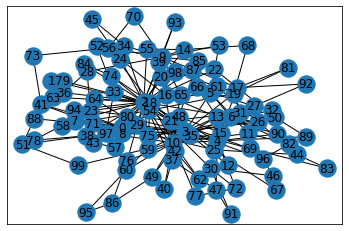

In [7]:
#DiG = nx.from_numpy_matrix(G, create_using=nx.DiGraph())
DiG = sfg
nx.draw_networkx(DiG, with_label = True) 
degs = []
for node in range(100):
    deg = DiG.degree(node)
    degs.append((node, deg))
    
degs_sorted = sorted(degs, key=lambda deg: deg[1])

print(degs_sorted)

In [40]:
print(nx.diameter(DiG))
print(nx.shortest_path(DiG, 93, 2))
print(nx.shortest_path(DiG, 5, 80))

5
[93, 9, 2]
[5, 3, 80]


In [7]:
swg_pth = path_gen([[8,7,1,2,4], 
                    [8,7,1,3,9]])
print(swg_pth)

[8, 7, 1, 2, 4]
[8, 7, 1, 3, 9]
[[[8, 7, 1], [7, 1, 1], [1, 2, 1], [2, 4, 1]], [[8, 7, 1], [7, 1, 1], [1, 3, 1], [3, 9, 1]]]


In [82]:
spaths = nx.all_simple_paths(sfg, 4, 3)
print(list(spaths))

[[4, 2, 0, 3], [4, 2, 0, 6, 3], [4, 2, 3], [4, 2, 5, 3], [4, 2, 7, 0, 3], [4, 2, 7, 0, 6, 3], [4, 2, 8, 3], [4, 2, 9, 3], [4, 3]]


In [43]:
sfg_pth = path_gen([[60, 48, 3, 0, 7, 2, 5], 
                    [32, 3, 2, 5, 11],
                    [52, 9, 2, 5, 3, 59],
                    [31, 21, 2, 5, 27],
                    [93, 9, 2, 5, 3, 80]])
print(sfg_pth)

[60, 48, 3, 0, 7, 2, 5]
[32, 3, 2, 5, 11]
[52, 9, 2, 5, 3, 59]
[31, 21, 2, 5, 27]
[93, 9, 2, 5, 3, 80]
[[[60, 48, 1], [48, 3, 1], [3, 0, 1], [0, 7, 1], [7, 2, 1], [2, 5, 1]], [[32, 3, 1], [3, 2, 1], [2, 5, 1], [5, 11, 1]], [[52, 9, 1], [9, 2, 1], [2, 5, 1], [5, 3, 1], [3, 59, 1]], [[31, 21, 1], [21, 2, 1], [2, 5, 1], [5, 27, 1]], [[93, 9, 1], [9, 2, 1], [2, 5, 1], [5, 3, 1], [3, 80, 1]]]


In [66]:
npg_pth = path_gen([[12,0,11,8,20], 
                    [8,12,29,26,1],
                    [13,21,5,2,7]])
print(npg_pth)

[12, 0, 11, 8, 20]
[8, 12, 29, 26, 1]
[13, 21, 5, 2, 7]
[[[12, 0, 1], [0, 11, 1], [11, 8, 1], [8, 20, 1]], [[8, 12, 1], [12, 29, 1], [29, 26, 1], [26, 1, 1]], [[13, 21, 1], [21, 5, 1], [5, 2, 1], [2, 7, 1]]]


In [50]:
flows, noiseless_flows, edge_adj, paths = flow_gen(sfg_G, sfg_pth[0:2], 2000, Range=2, zero_centered=True, \
                                                   processed_paths = False, noise_level=0.2)

Edges:
 [[0, 2], [0, 3], [0, 4], [0, 7], [0, 25], [0, 41], [0, 43], [0, 88], [0, 94], [1, 2], [2, 0], [2, 1], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [2, 9], [2, 14], [2, 20], [2, 21], [2, 22], [2, 24], [2, 30], [2, 33], [2, 34], [2, 37], [2, 38], [2, 39], [2, 42], [2, 43], [2, 54], [2, 55], [2, 61], [2, 63], [2, 64], [2, 66], [2, 74], [2, 75], [2, 76], [2, 79], [2, 84], [2, 87], [2, 94], [3, 0], [3, 2], [3, 5], [3, 8], [3, 10], [3, 12], [3, 13], [3, 19], [3, 26], [3, 29], [3, 32], [3, 37], [3, 38], [3, 42], [3, 48], [3, 49], [3, 50], [3, 59], [3, 69], [3, 71], [3, 75], [3, 80], [3, 96], [4, 0], [4, 2], [4, 10], [4, 12], [4, 15], [4, 17], [4, 47], [4, 72], [4, 89], [4, 90], [5, 2], [5, 3], [5, 6], [5, 9], [5, 11], [5, 27], [5, 53], [5, 87], [6, 2], [6, 5], [6, 82], [7, 0], [7, 2], [8, 2], [8, 3], [9, 2], [9, 5], [9, 14], [9, 17], [9, 28], [9, 34], [9, 52], [9, 53], [9, 56], [9, 65], [9, 70], [9, 85], [9, 93], [10, 3], [10, 4], [10, 11], [10, 13], [10, 15], [10, 16], [10, 18], [

In [71]:
print('noiseless:\n',noiseless_flows[0:1])
print('with noise:\n',flows[0:1])
noiseless_flows.shape

noiseless:
 [[ 0.          0.          0.         -0.23747479  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.99925106  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.99925106  0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -0.43117308  0.          0.
  -0.23747479  0.          0.          0.          0.          0

(2000, 310)

In [54]:
np.save('flows.npy', flows)
np.save('noiseless_flows.npy', noiseless_flows)
np.save('adj.npy', edge_adj)
np.save('paths.npy', paths)
np.save('graph.npy', G)

In [16]:
print(noiseless_flows[0])

[ 0.          0.          0.          0.          0.          0.
 48.98215367  0.          0.          0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.         48.98215367  0.          0.          0.
  0.          0.          0.         48.98215367  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
